# Importing library

In [2]:
import cupy
import matplotlib.pyplot as plt
import numpy as np
import math
from numba import cuda
from PIL import Image, ImageEnhance
from skimage import data
from skimage.transform import resize
from sklearn.cluster import KMeans

In [2]:
gpu = cuda.get_current_device()
print(f"GPU Device = {gpu.name}")
print(f"MAX_THREADS_PER_BLOCK = {str(gpu.MAX_THREADS_PER_BLOCK)}")
print(f"MAX_BLOCK_DIM_X = {str(gpu.MAX_BLOCK_DIM_X)}")
print(f"MAX_BLOCK_DIM_Y = {str(gpu.MAX_BLOCK_DIM_Y)}")
print(f"MAX_BLOCK_DIM_Z = {str(gpu.MAX_BLOCK_DIM_Z)}")
print(f"MAX_GRID_DIM_X = {str(gpu.MAX_GRID_DIM_X)}")
print(f"MAX_GRID_DIM_Y = {str(gpu.MAX_GRID_DIM_Y)}")
print(f"MAX_GRID_DIM_Z = {str(gpu.MAX_GRID_DIM_Z)}")
print(f"MAX_SHARED_MEMORY_PER_BLOCK = {str(gpu.MAX_SHARED_MEMORY_PER_BLOCK)}")
print(f"ASYNC_ENGINE_COUNT = {str(gpu.ASYNC_ENGINE_COUNT)}")
print(f"CAN_MAP_HOST_MEMORY = {str(gpu.CAN_MAP_HOST_MEMORY)}")
print(f"MULTIPROCESSOR_COUNT = {str(gpu.MULTIPROCESSOR_COUNT)}")
print(f"WARP_SIZE = {str(gpu.WARP_SIZE)}")
print(f"UNIFIED_ADDRESSING = {str(gpu.UNIFIED_ADDRESSING)}")
print(f"PCI_BUS_ID = {str(gpu.PCI_BUS_ID)}")
print(f"PCI_DEVICE_ID = {str(gpu.PCI_DEVICE_ID)}")

GPU Device = b'NVIDIA GeForce GTX 1650'
MAX_THREADS_PER_BLOCK = 1024
MAX_BLOCK_DIM_X = 1024
MAX_BLOCK_DIM_Y = 1024
MAX_BLOCK_DIM_Z = 64
MAX_GRID_DIM_X = 2147483647
MAX_GRID_DIM_Y = 65535
MAX_GRID_DIM_Z = 65535
MAX_SHARED_MEMORY_PER_BLOCK = 49152
ASYNC_ENGINE_COUNT = 2
CAN_MAP_HOST_MEMORY = 1
MULTIPROCESSOR_COUNT = 14
WARP_SIZE = 32
UNIFIED_ADDRESSING = 1
PCI_BUS_ID = 1
PCI_DEVICE_ID = 0


# Utility functions

In [3]:
def resize_img(img, new_width, new_height):
    return resize(img, (new_width, new_height), order = 0, preserve_range = True, anti_aliasing = False).astype('uint8')


def rgb2gray(rgb_image):
    """
    https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
    """
    return np.dot(rgb_image[..., :3], [0.299, 0.587, 0.114])


def pixel_neighbours(matrix, x, y, d):
    rows, cols = matrix.shape
    i, j = x, y
    d = rows - 1 if d >= rows - 1 else d

    r_min = i - d if i - d >= 0 else 0
    r_max = i + d if i + d < rows else rows - 1

    c_min = j - d if j - d >= 0 else 0
    c_max = j + d if j + d < cols else cols - 1

    neighbours = []
    for x in range(r_min, r_max + 1):
        for y in range(c_min, c_max + 1):
            neighbours.append(matrix[x, y])

    return np.asarray(neighbours)


def calc_variance(w_matrix):
    """
    Calculate variance
    :param w_matrix:
    :return:
    """
    w = w_matrix.copy().reshape(-1)
    w = w[np.logical_not(np.isnan(w))]

    length = w.shape[0]
    average = w.sum() / length
    variance = (w - average) ** 2
    return variance.sum() / length


def get_all_vertices(image):
    """
    Denotes all pixels as nodes of a graph
    """
    return image.reshape(-1)


def testing(image, new_size, threshold):
    # Input is the image I
    img = Image.open(image)
    img = np.asarray(img)
    plt.figure(1)
    plt.title("Input is the image I")
    plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255)

    # After resize
    img = resize_img(img, new_size, new_size)
    plt.figure(2)
    plt.title(f"After resize\n({new_size}x{new_size})")
    plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255)

    # Threshold
    r = threshold

    # Runner with GPU
    symmetrical_matrix = SymmetricMatrixParallel(img, r)

    # The input image must be grayscale.
    # Otherwise, constructor will convert it from rgb to grayscale.
    plt.figure(3)
    plt.title("After being initialized")
    plt.imshow(symmetrical_matrix.img, cmap='gray', vmin=0, vmax=255)

    # Calculate matrix W
    W = symmetrical_matrix.get_matrix_w()
    D = np.diag(W.sum(axis = 1))
    L = D - W
    # Calculate eigenvalues and eigenvectors
    d_half = np.diag(W.sum(axis = 1) ** (-1 / 2))
    L = cupy.asarray(np.dot(np.dot(d_half, L), d_half))
    eig_values, eig_vectors = lanczos_gpu(A = L)
    plt.show()

    # Clustering with K-means
    # The number of clusters to form as well as the number of centroids to generate.
    k = 4
    # The number of smallest vector
    n = 2
    # Select the smallest vector at positions 1 up to n+1 and cluster
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(eig_vectors[:, 1:n + 1])
    labels = kmeans.labels_
    # Output
    np.set_printoptions(threshold = np.inf)
    print("Clustering with K-means\n")
    print(labels)
    # Plotting the results after Kmeans
    filtered_label0 = eig_vectors[labels == 0]
    filtered_label1 = eig_vectors[labels == 1]
    filtered_label2 = eig_vectors[labels == 2]
    filtered_label3 = eig_vectors[labels == 3]
    plt.scatter(filtered_label0[:, 0], filtered_label0[:, 1], color = 'red')
    plt.scatter(filtered_label1[:, 0], filtered_label1[:, 1], color = 'black')
    plt.scatter(filtered_label2[:, 0], filtered_label2[:, 1], color = 'blue')
    plt.scatter(filtered_label3[:, 0], filtered_label3[:, 1], color = 'green')
    plt.show()

    show_result(symmetrical_matrix.img, labels, k)


def show_result(image, labels, k):
    images = []

    # For each with cluster number
    for i in range(k):
        tmp_img = image.copy().reshape(-1)
        '''
        For each from the number of labels, if the i-th cluster is not equal to that label, that pixel will have 
        a value of 255 (White)
        '''
        for index in range(labels.shape[0]):
            if i != labels[index]:
                tmp_img[index] = 255
        images.append(tmp_img.reshape(image.shape))

    for img in images:
        plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255)
        plt.show()

    fig, ax = plt.subplots(ncols = k + 1, sharex = True, sharey = True, figsize = (25, 25))
    ax[0].imshow(image, cmap = 'gray')
    ax[0].set_title("Original image\n(after resize)")
    for i in range(1, k + 1):
        ax[i].imshow(images[i - 1], cmap = 'gray', vmin = 0, vmax = 255)
        ax[i].set_title(i)

    for a in ax:
        a.axis('off')

# Define class and functions to calculate symmetric matrix

In [4]:
@cuda.jit
def calc_features_matrix(f_matrix, neighbours_matrix, vertices):
    i, j = cuda.grid(2)
    if i < f_matrix.shape[0] and j < f_matrix.shape[1]:
        value = neighbours_matrix[i, j]
        if not math.isnan(value):
            f = math.sqrt(math.pow(vertices[i] - vertices[np.int32(value)], 2))
            f_matrix[i, j] = f


@cuda.jit
def calc_distance_matrix(d_matrix, neighbours_matrix, vertices):
    i, j = cuda.grid(2)
    if i < d_matrix.shape[0] and j < d_matrix.shape[1]:
        value = neighbours_matrix[i, j]
        if not math.isnan(value):
            i_float = np.float64(i)
            pos_x_i = math.floor(i_float // vertices)
            pos_y_i = math.floor(i_float % vertices)
            pos_x_value = math.floor(value // vertices)
            pos_y_value = math.floor(value % vertices)
            pos_x_final = pos_x_i - pos_x_value
            pos_y_final = pos_y_i - pos_y_value
            d = math.pow(pos_x_final, 2) + math.pow(pos_y_final, 2)
            d = math.sqrt(d)
            d_matrix[i, j] = d


@cuda.jit(device = True)
def get_index(arr, value):
    for i in range(arr.shape[0]):
        if value == arr[i]:
            return i
    return -1


@cuda.jit
def calc_w(w_matrix, neighbours_matrix, f_matrix, d_matrix, vertices, sigma_i, sigma_x):
    i, j = cuda.grid(2)
    if i < vertices and j < vertices:
        index = get_index(neighbours_matrix[i], j)
        if index >= 0:
            f = f_matrix[i, index] ** 2
            d = d_matrix[i, index] ** 2
            w_matrix[i, j] = math.exp(-f / (sigma_i)) * math.exp(-d / (sigma_x))
        else:
            w_matrix[i, j] = 0


class SymmetricMatrixParallel:
    def __init__(self, img, r):
        self.r = r
        self.N = img.shape[0] * img.shape[1]
        self.LIMIT = (self.r * 2 + 1) ** 2 if (self.r * 2 + 1) ** 2 < self.N else self.N
        # The input image must be grayscale. If not true, convert it from rgb to grayscale.
        if len(img.shape) > 2:
            img = rgb2gray(img)
        self.img = img
        self.neighbors_matrix = self.get_neighbors_matrix()
        self.dist_matrix = self.get_distance_matrix()
        self.vertices = get_all_vertices(img)
        self.sigma_I = self.get_sigma_i()
        self.sigma_X = self.get_sigma_x()
        self.feat_matrix = self.get_feature_matrix()

    def get_position(self, index):
        pos = np.zeros(2)
        pos[0] = np.floor(index // self.img.shape[0])
        pos[1] = np.floor(index % self.img.shape[0])
        return pos.astype(int)

    def calc_distance(self, index_i, index_j):
        """
        Calculate distance between 2 pixel with input is 2 index in list all vertex
        """
        return np.linalg.norm(self.get_position(index_i) - self.get_position(index_j))

    def get_sigma_i(self):
        """
        :return: sigma I
        """
        variance = calc_variance(self.img / self.img.max())
        return variance

    def get_sigma_x(self):
        """
        :return: sigma X
        """
        variance = calc_variance(self.dist_matrix)
        return variance

    def get_distance_matrix(self):
        dist_matrix = np.zeros((self.N, self.LIMIT), dtype = np.float64)
        dist_matrix[:] = math.nan

        threads_per_block = (32, 32)
        blocks_per_grid_x = math.ceil(dist_matrix.shape[0] / threads_per_block[0])
        blocks_per_grid_y = math.ceil(dist_matrix.shape[1] / threads_per_block[1])
        blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

        d_dist = cuda.to_device(dist_matrix)
        d_neighbors_matrix = cuda.to_device(self.neighbors_matrix)

        calc_distance_matrix[blocks_per_grid, threads_per_block](d_dist, d_neighbors_matrix,
                                                                 np.float64(self.img.shape[1]))
        return d_dist.copy_to_host()

    def get_feature_matrix(self):
        """
        Calculate the feature matrix
        :return: Feature matrix (F)
        """
        feat_matrix = np.zeros((self.N, self.LIMIT), dtype = np.float64)
        feat_matrix[:] = math.nan

        threads_per_block = (32, 32)
        blocks_per_grid_x = math.ceil(feat_matrix.shape[0] / threads_per_block[0])
        blocks_per_grid_y = math.ceil(feat_matrix.shape[1] / threads_per_block[1])
        blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

        d_feat = cuda.to_device(feat_matrix)
        d_neighbors_matrix = cuda.to_device(self.neighbors_matrix)
        d_vertices = cuda.to_device(self.vertices)

        calc_features_matrix[blocks_per_grid, threads_per_block](d_feat, d_neighbors_matrix, d_vertices)

        feat_matrix = d_feat.copy_to_host()
        return feat_matrix / np.nanmax(feat_matrix)

    def get_neighbors_matrix(self):
        """
        Find the surrounding pixels within the distance limit r
        :return: Neighbors matrix
        """
        pos_matrix = np.arange(self.N).reshape(self.img.shape)
        neigh_matrix = []

        for i in range(self.img.shape[0]):
            for j in range(self.img.shape[1]):
                neigh_pixels = np.zeros((self.LIMIT,), dtype = np.float64)
                neigh_pixels[:] = np.nan
                output = np.copy(pixel_neighbours(pos_matrix, i, j, self.r))
                for k in range(output.shape[0]):
                    neigh_pixels[k] = output[k]
                neigh_matrix.append(neigh_pixels)
        return np.asarray(neigh_matrix)

    def get_matrix_w(self):
        w = np.zeros((self.N, self.N), dtype = np.float64)
        """
        i, j are position of pixels i, j in all vertices (1D array)
        pixel_i, pixel_j are gray level value of pixel_i and pixel_j
        """

        d_w = cuda.to_device(w)
        d_n = cuda.to_device(self.neighbors_matrix)
        d_f = cuda.to_device(self.feat_matrix)
        d_d = cuda.to_device(self.dist_matrix)
        d_size = self.vertices.size
        d_sigma_i = self.sigma_I
        d_sigma_x = self.sigma_X

        threads_per_block = (32, 32)
        blocks_per_grid_x = math.ceil(w.shape[0] / threads_per_block[0])
        blocks_per_grid_y = math.ceil(w.shape[1] / threads_per_block[1])
        blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

        calc_w[blocks_per_grid, threads_per_block](
            d_w, d_n, d_f, d_d, d_size, d_sigma_i, d_sigma_x)
        w = d_w.copy_to_host()
        cuda.defer_cleanup()
        return w / w.max()


# Lanczos algorithm

[Lanczos Algorithm - Wikipedia](https://en.wikipedia.org/wiki/Lanczos_algorithm)

[References - StackExchange: Quality of eigenvalue approximation in Lanczos method](https://scicomp.stackexchange.com/questions/23536/quality-of-eigenvalue-approximation-in-lanczos-method)

In [5]:
def lanczos_cpu(A):
    n = A.shape[0]
    m = int(0.25 * np.sqrt(A.shape[0]))
    if m > n:
        m = n

    V = np.zeros((n, m), dtype = np.float64)
    T = np.zeros((m, m), dtype = np.float64)
    V[:, 0] = np.random.rand(n)
    V[:, 0] = V[:, 0] / np.sqrt(np.dot(V[:, 0], V[:, 0]))

    w = A.dot(V[:, 0])
    alpha = w.dot(V[:, 0])
    w = w - alpha * V[:, 0]

    T[0, 0] = alpha

    for i in range(1, m):
        beta = np.linalg.norm(w)
        if beta != 0.0:
            V[:, i] = w / beta

            w = A.dot(V[:, i])
            alpha = w.dot(V[:, i])
            w = w - alpha * V[:, i] - beta * V[:, i - 1]

            for j in range(i):
                tmp_arr = np.dot(w, V[:, j])
                if tmp_arr != 0.0:
                    w -= tmp_arr * V[:, j]

            T[j, j] = alpha
            T[j - 1, j] = beta
            T[j, j - 1] = beta

    eig_values, eig_vectors = np.linalg.eigh(T)
    eig_vectors = V.dot(eig_vectors)
    return eig_values, eig_vectors


def lanczos_gpu(A):
    n = A.shape[0]
    m = int(0.25 * np.sqrt(A.shape[0]))
    if m > n:
        m = n
    V = cupy.zeros((n, m), dtype = np.float64)
    T = cupy.zeros((m, m), dtype = np.float64)
    V[:, 0] = cupy.random.rand(n)
    V[:, 0] = V[:, 0] / cupy.sqrt(cupy.dot(V[:, 0], V[:, 0]))

    w = A.dot(V[:, 0])
    alpha = w.dot(V[:, 0])
    w = w - alpha * V[:, 0]

    T[0, 0] = alpha

    for i in range(1, m):
        beta = cupy.linalg.norm(w)
        if beta != 0.0:
            V[:, i] = w / beta

            w = A.dot(V[:, i])
            alpha = w.dot(V[:, i])
            w = w - alpha * V[:, i] - beta * V[:, i - 1]

            for j in range(i):
                tmp_arr = cupy.dot(w, V[:, j])
                if tmp_arr != 0.0:
                    w -= tmp_arr * V[:, j]

            T[j, j] = alpha
            T[j - 1, j] = beta
            T[j, j - 1] = beta

    eig_values, eig_vectors = cupy.linalg.eigh(T)
    eig_vectors = V.dot(eig_vectors)
    return cupy.asnumpy(eig_values), cupy.asnumpy(eig_vectors)

# Test case 1

## Input is the image I

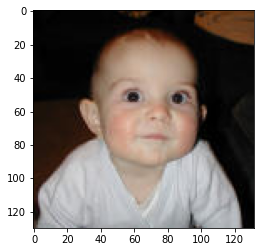

In [6]:
img = Image.open("dataset/3.jpg")
img = np.asarray(img)
plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255)

## After resize

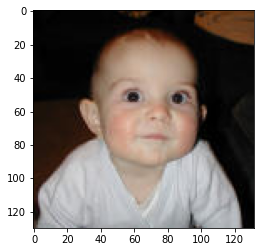

In [7]:
img = resize_img(img, img.shape[0], img.shape[1])
plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255)

## Initialize with threshold r

In [8]:
# Threshold
r = 25

# Runner with GPU
symmetrical_matrix = SymmetricMatrixParallel(img, r)

## After being initialized


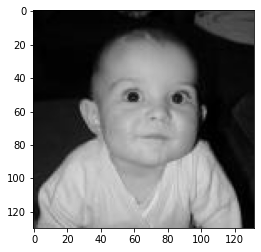

In [9]:
# The input image must be grayscale. If not true, constructor will convert it from rgb to grayscale.
plt.imshow(symmetrical_matrix.img, cmap='gray', vmin=0, vmax=255)

## Calculate matrix W

In [11]:
W = symmetrical_matrix.get_matrix_w()

In [12]:
D = np.diag(W.sum(axis = 1))
L = D - W

In [13]:
print(symmetrical_matrix.get_sigma_x())
print(symmetrical_matrix.get_sigma_i())
# print(W)


53.493208799851224
0.12382960223542654


## Calculate eigenvalues and eigenvectors

In [14]:
d_half = np.diag(W.sum(axis = 1) ** (-1 / 2))
L = cupy.asarray(np.dot(np.dot(d_half, L), d_half))
eig_values, eig_vectors = lanczos_gpu(A = L)

In [15]:
eig_values

array([-0.19817725,  0.00670002,  0.02075913,  0.03573113,  0.05401813,
        0.07594448,  0.10389015,  0.14010068,  0.16093498,  0.21422787,
        0.24710404,  0.29722058,  0.34326874,  0.38655019,  0.42824187,
        0.47605418,  0.52843562,  0.57463913,  0.62508686,  0.67952443,
        0.72151747,  0.76322604,  0.80707707,  0.84089511,  0.87817431,
        0.90660942,  0.93427756,  0.94788337,  0.95790841,  0.9753577 ,
        0.9878921 ,  0.99670329])

In [16]:
eig_vectors

array([[-0.00354376, -0.0022596 ,  0.00286326, ...,  0.00472459,
        -0.01620438, -0.04286054],
       [-0.00160631, -0.00267598,  0.00261239, ...,  0.00575253,
        -0.01325229, -0.01499792],
       [-0.00196622, -0.00300755,  0.00238603, ...,  0.00587719,
        -0.00797142,  0.00541122],
       ...,
       [ 0.0052068 ,  0.00333711,  0.01100709, ...,  0.03917339,
         0.01008141, -0.00313421],
       [ 0.00717124,  0.00313952,  0.01044612, ...,  0.05078076,
         0.01516321,  0.00244698],
       [ 0.00499228,  0.00286808,  0.00998296, ...,  0.05412533,
         0.02295175,  0.02085269]])

In [17]:
# Chỉ lấy phần thực để gom cụm vì phần ảo bằng 0
eig_values = eig_values.real
eig_vectors = eig_vectors.real
# Sort eig_values, eig_vectors
eig_values = eig_values[np.argsort(eig_values)]
eig_vectors = eig_vectors[:, np.argsort(eig_values)]

## Clustering with K-means

In [18]:
# The number of clusters to form as well as the number of centroids to generate.
k = 4
# The number of smallest vector
n = 2

In [19]:
# Select the smallest vector at positions 1 up to n+1 and cluster
kmeans = KMeans(n_clusters = k)
kmeans.fit(eig_vectors[:, 1:n + 1])
labels = kmeans.labels_
# Output
np.set_printoptions(threshold = np.inf)
print(labels)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

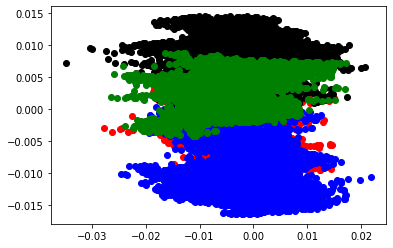

In [20]:
filtered_label0 = eig_vectors[labels == 0]
filtered_label1 = eig_vectors[labels == 1]
filtered_label2 = eig_vectors[labels == 2]
filtered_label3 = eig_vectors[labels == 3]

# Plotting the results after Kmeans
plt.scatter(filtered_label0[:, 0], filtered_label0[:, 1], color = 'red')
plt.scatter(filtered_label1[:, 0], filtered_label1[:, 1], color = 'black')
plt.scatter(filtered_label2[:, 0], filtered_label2[:, 1], color = 'blue')
plt.scatter(filtered_label3[:, 0], filtered_label3[:, 1], color = 'green')
plt.show()

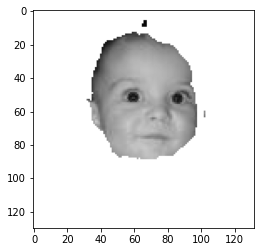

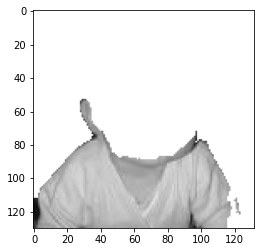

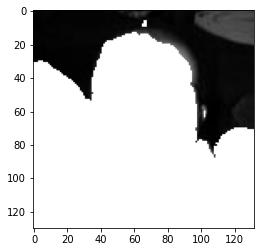

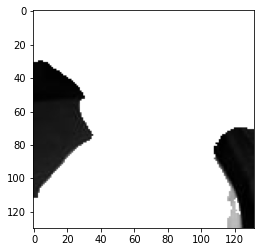

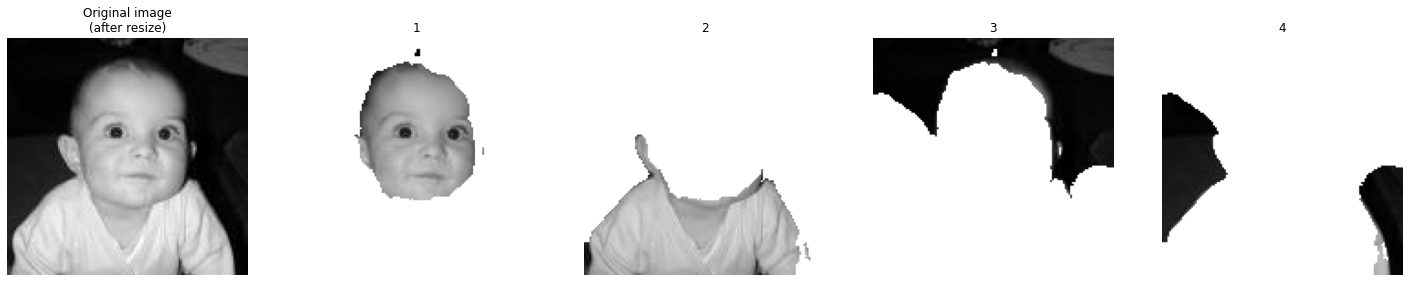

In [21]:
show_result(symmetrical_matrix.img, labels, k)

# Test case 2

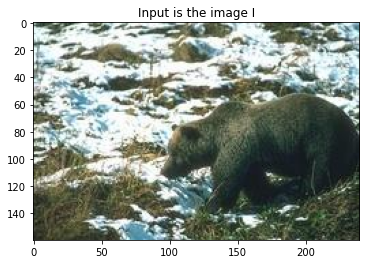

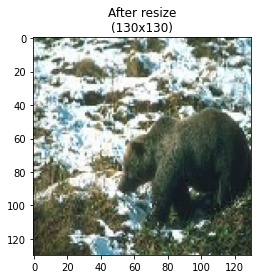

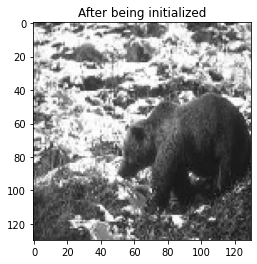

Clustering with K-means

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 2 2 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 3 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2


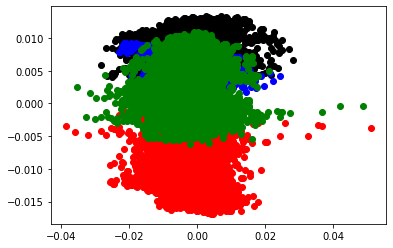

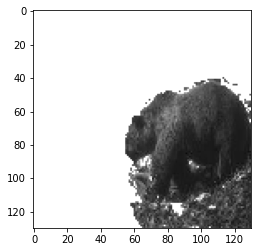

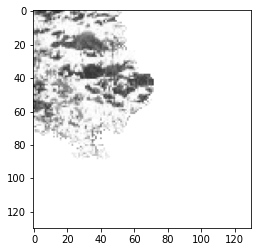

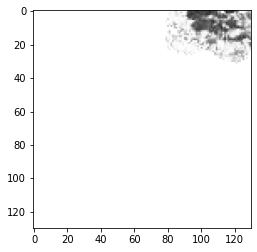

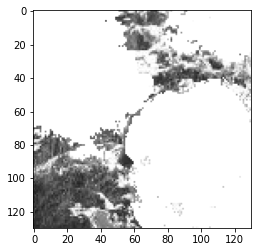

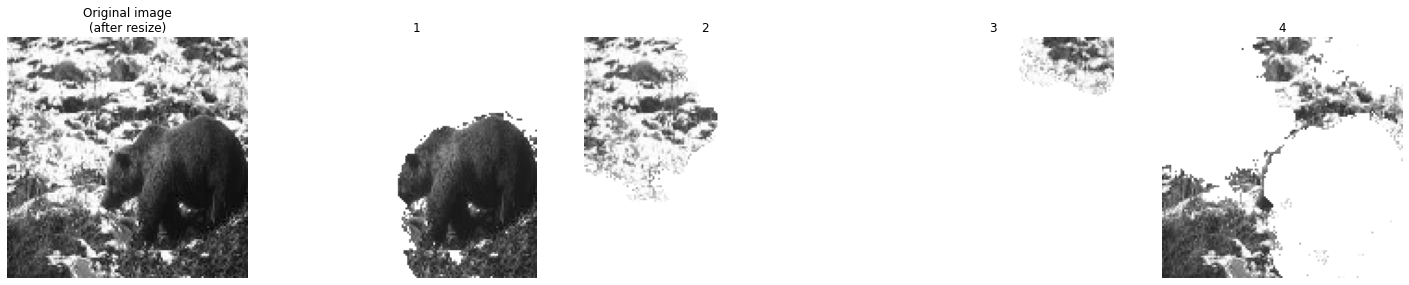

In [6]:
testing("dataset/2.jpg", 130, 21)

# Test case 3

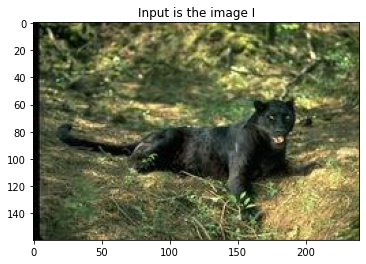

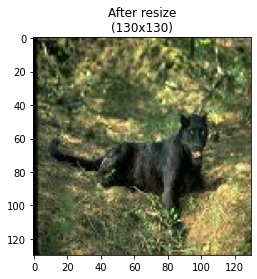

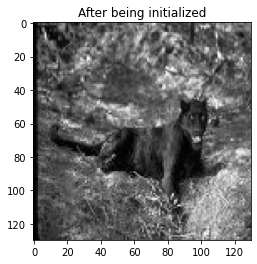

Clustering with K-means

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2
 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 2 2 0
 0 0 0 0 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2


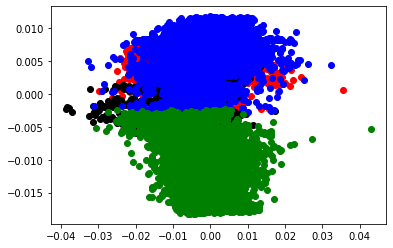

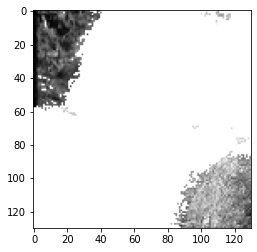

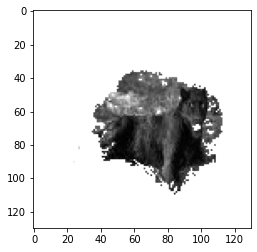

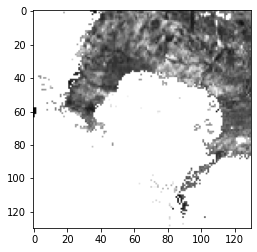

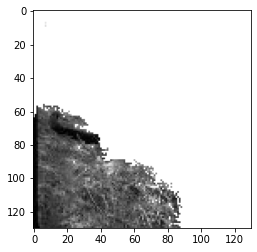

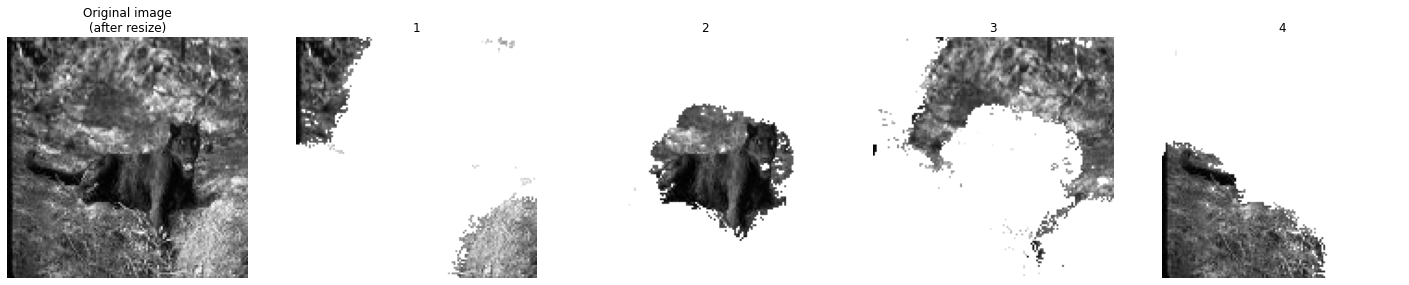

In [7]:
testing("dataset/1.jpg", 130, 25)

# Test case 4

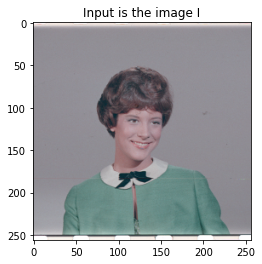

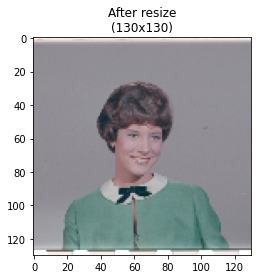

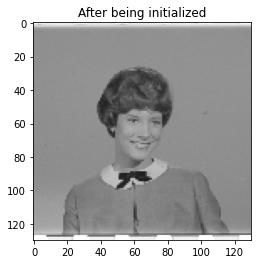

Clustering with K-means

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 3 0 3 3 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0


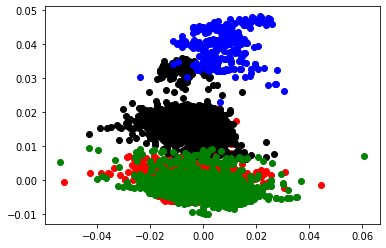

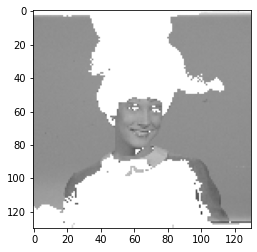

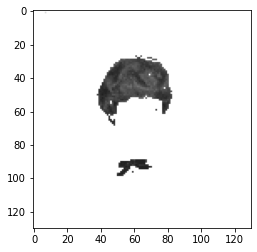

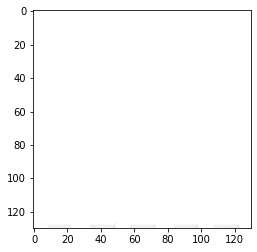

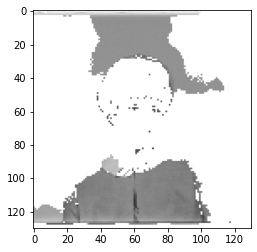

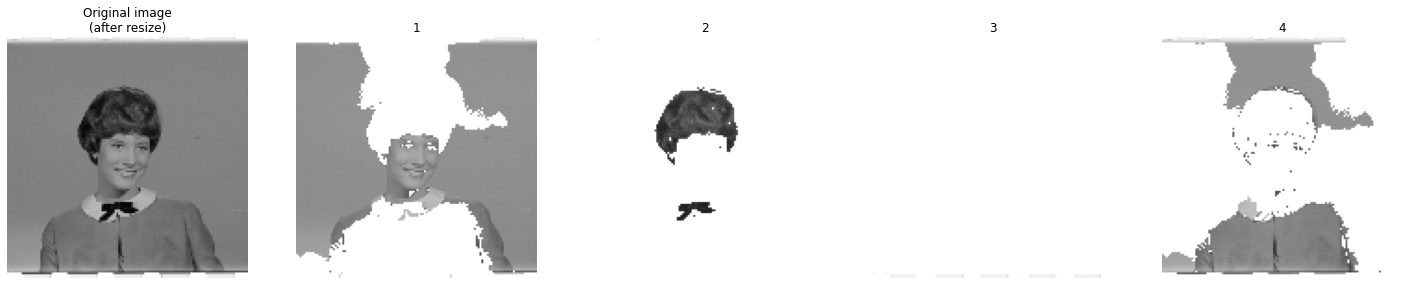

In [5]:
testing("dataset/misc/4.1.03.tiff", 130, 21)

## Increase the contrast of an image

In [6]:
img = Image.open("dataset/misc/4.1.03.tiff")
enhancer = ImageEnhance.Contrast(img)
enhanced_img = enhancer.enhance(4.0)
enhanced_img.save("dataset/4.1.03_edited.png")

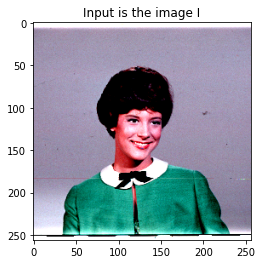

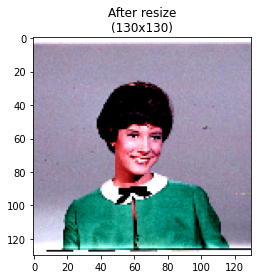

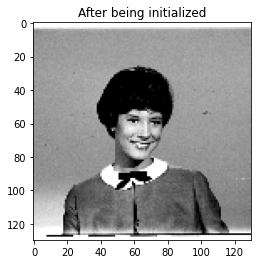

Clustering with K-means

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2


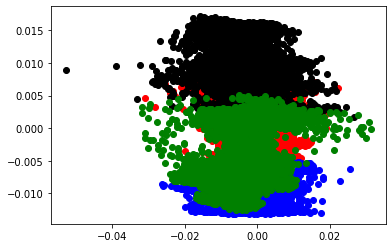

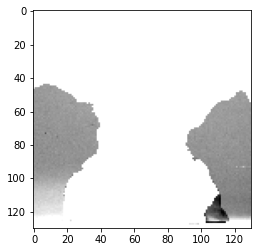

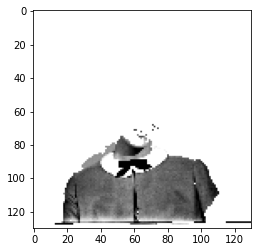

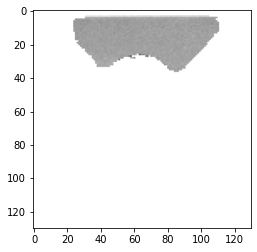

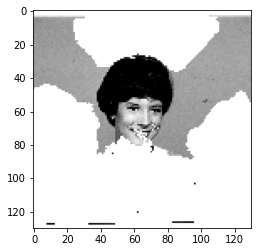

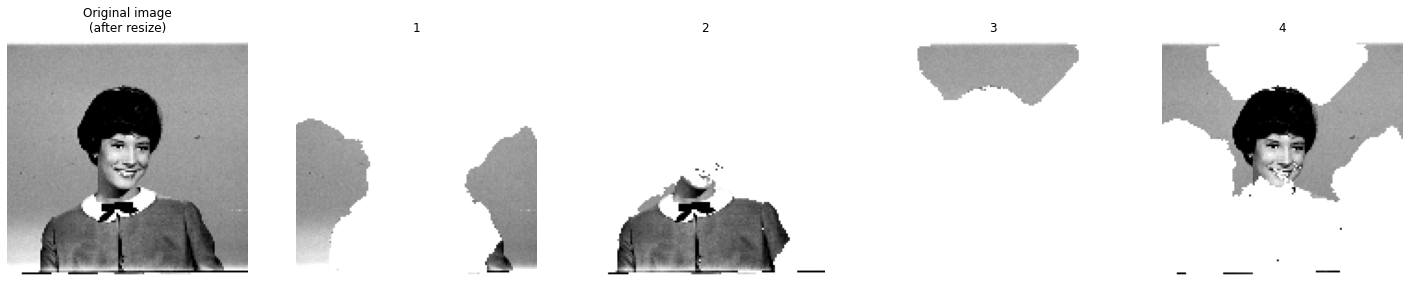

In [6]:
testing("dataset/4.1.03_edited.png", 130, 21)